**Sarcasm Detection Using LSTM**

M. Rivqi Al Varras

dataset : News Headlines Dataset For Sarcasm Detection

Sumber kaggle : https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/data


**Import library**

In [1]:
import json
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau


import warnings
warnings.filterwarnings("ignore")

**Loading The Dataset**

In [4]:
df_News = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df_2 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
df_News.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


**Joining the two Datasets**

In [5]:
df_News = pd.concat([df_News, df_2], ignore_index=True)
df_News.shape

(55328, 3)

**Exploratory Data Analysis**

In [6]:
df_News.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55328 entries, 0 to 55327
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  55328 non-null  int64 
 1   headline      55328 non-null  object
 2   article_link  55328 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [8]:
# Melihat beberapa berita yang bersifat sarkastik
df_News[df_News.is_sarcastic == 1].head(5)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...


In [10]:
# Melihat beberapa legitimasi berita
df_News[df_News.is_sarcastic == 0].head(5)

,is_sarcastic,headline,article_link
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


**Target Column Distribution**

In [11]:
df_News.is_sarcastic.value_counts()

0    29970
1    25358
Name: is_sarcastic, dtype: int64

**Dataset ini tampak seimbang antara berita yang bersifat sarkastik dan berita yang sah/legitim.**

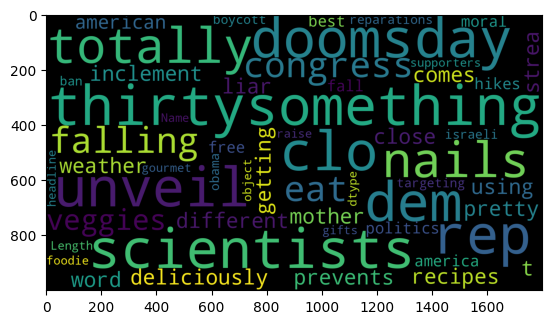

In [13]:
wordcloud = WordCloud(background_color='black',
                    stopwords = STOPWORDS,
                    max_words = 100,
                    random_state = 101,
                    width=1800,
                    height=1000)
wordcloud.generate(str(df_News['headline']))
plt.imshow(wordcloud)

**News Headline length Distribution**

In [14]:
df_News['headline_len'] = df_News.headline.apply(lambda x: len(x.split()))

In [15]:
sarcastic = df_News[df_News.is_sarcastic == 1]
legit = df_News[df_News.is_sarcastic == 0]

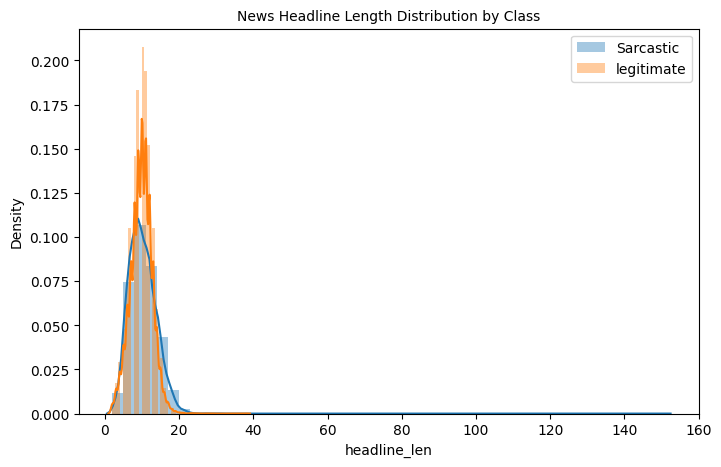

In [16]:
plt.figure(figsize=(8,5))
sns.distplot(sarcastic.headline_len, hist= True, label= 'Sarcastic')
sns.distplot(legit.headline_len, hist= True, label= 'legitimate')
plt.legend()
plt.title('News Headline Length Distribution by Class', fontsize = 10)
plt.show()

In [20]:
df_News

,is_sarcastic,headline,headline_len
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails why congress is falling...,13
2,0,eat your veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word 'strea...,9
...,...,...,...
55323,0,american politics in moral free-fall,5
55324,0,america's best 20 hikes,4
55325,0,reparations and obama,3
55326,0,israeli ban targeting boycott supporters raise...,8


In [21]:
df_News.groupby(['is_sarcastic']).headline_len.mean()

is_sarcastic
0     9.815616
1    10.111917
Name: headline_len, dtype: float64

In [22]:
df_News.groupby(['is_sarcastic']).headline_len.max()

is_sarcastic
0     38
1    151
Name: headline_len, dtype: int64

Secara rata-rata, sebagian besar judul berita memiliki panjang yang sama, namun dalam beberapa kasus, judul berita yang bersifat sarkastik lebih panjang.

**Stratified Split**

In [24]:
headlines = df_News['headline']
labels = df_News['is_sarcastic']

In [25]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(headlines, labels, test_size=0.2, stratify=labels, random_state=42)


In [26]:
train_labels.value_counts()

0    23976
1    20286
Name: is_sarcastic, dtype: int64

**Converting News Headlines into Sequences of tokens**

In [27]:
#Defining Hyperparameters to be used

max_words = 30000     # how many unique words to use (i.e num rows in embedding vector)
max_len = 70       # max number of words in a headline to use
oov_token = '00_V'    # for the words which are not in training samples
padding_type = 'post'   # padding type
trunc_type = 'post'    # truncation for headlines longer than max length
embed_size = 100    # how big is each word vector

In [28]:
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

In [29]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [30]:
train_sequences

array([[  316,    91,   665, ...,     0,     0,     0],
       [   69,  4765,   318, ...,     0,     0,     0],
       [  361,  1165,     6, ...,     0,     0,     0],
       ...,
       [   12,    97,   118, ...,     0,     0,     0],
       [11019,     2,  1389, ...,     0,     0,     0],
       [16905, 16906,    99, ...,     0,     0,     0]], dtype=int32)

 **LSTM (Long Short Term Memory)**

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 100)           3000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 70, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 70, 32)            17024     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0

In [32]:
history_lstm = model_lstm.fit(train_sequences, train_labels, batch_size=32, epochs=5,
                    validation_data=(test_sequences, test_labels),
                    callbacks=[rlrp] ,verbose=1)

Epoch 1/5
1384/1384 [==============================] - 203s 142ms/step - loss: 0.3717 - accuracy: 0.8368 - val_loss: 0.2289 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 2/5
1384/1384 [==============================] - 190s 138ms/step - loss: 0.1440 - accuracy: 0.9480 - val_loss: 0.1819 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 3/5
1384/1384 [==============================] - 190s 137ms/step - loss: 0.0784 - accuracy: 0.9720 - val_loss: 0.1672 - val_accuracy: 0.9448 - lr: 0.0010
Epoch 4/5
1384/1384 [==============================] - 195s 141ms/step - loss: 0.0468 - accuracy: 0.9839 - val_loss: 0.1675 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 5/5
1384/1384 [==============================] - 192s 139ms/step - loss: 0.0260 - accuracy: 0.9921 - val_loss: 0.1686 - val_accuracy: 0.9579 - lr: 0.0010


**Progress Training**

╒══════════════╤════════════╤══════════════╕
│ Metric       │   Training │   Validation │
╞══════════════╪════════════╪══════════════╡
│ Accuracy (%) │   99.21    │     95.79    │
├──────────────┼────────────┼──────────────┤
│ Loss         │    0.02601 │      0.16863 │
╘══════════════╧════════════╧══════════════╛


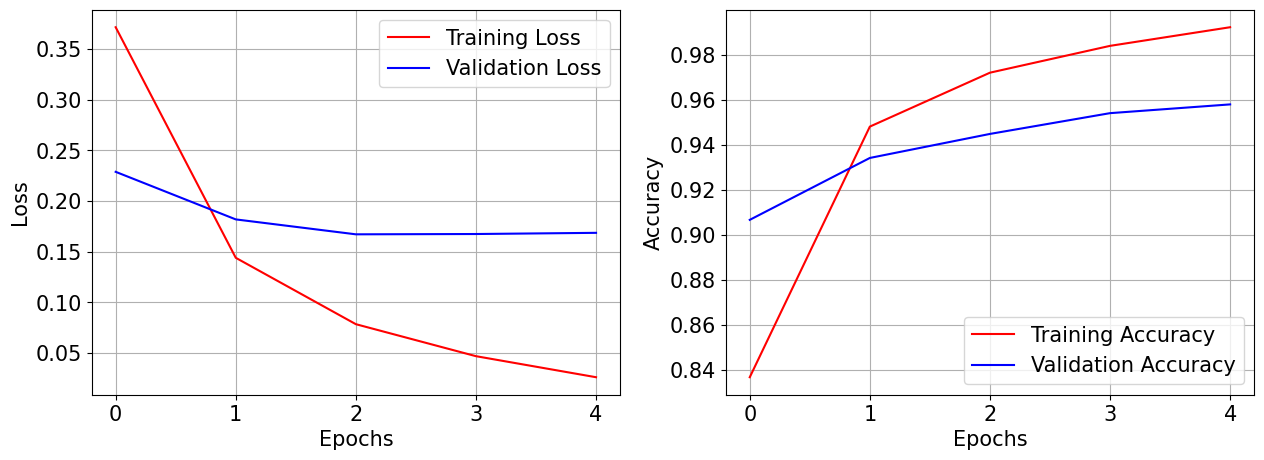

In [35]:
#  Melihat progres training
from tabulate import tabulate

# Menampilkan laporan pelatihan dalam tabel array
table = [
    ["Metric", "Training", "Validation"],
    ["Accuracy (%)", f'{np.round(history_lstm.history["accuracy"][-1]*100, 2):.2f}', f'{np.round(history_lstm.history["val_accuracy"][-1]*100, 2):.2f}'],
    ["Loss", f'{np.round(history_lstm.history["loss"][-1], 5):.5f}', f'{np.round(history_lstm.history["val_loss"][-1], 5):.5f}']
]

table_str = tabulate(table, headers="firstrow", tablefmt="fancy_grid")
print(table_str)


def plot_training_results(history):
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(121)
    plt.grid(True)
    plt.plot(history["loss"], 'r', label="Training Loss")
    plt.plot(history["val_loss"], 'b', label="Validation Loss")
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.legend(fontsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)

    # Plot accuracy
    plt.subplot(122)
    plt.grid(True)
    plt.plot(history["accuracy"], 'r', label="Training Accuracy")
    plt.plot(history["val_accuracy"], 'b', label="Validation Accuracy")
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel("Accuracy", fontsize=15)
    plt.legend(fontsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)

# Use the function to plot training results
plot_training_results(history_lstm.history)
plt.show()